# Power Spectrum Analysis

### IMPORTING REQUIRED MODULES

In [1]:
%matplotlib inline
#import mpld3 #need to install with "pip install mpld3"
#mpld3.enable_notebook()
import numpy as np
import matplotlib.pyplot as plt

# Use seaborn styles for nice-looking plots
import seaborn; seaborn.set()

import time
import sys
import glob


import ipywidgets as widgets
from ipywidgets import Layout, interact, fixed

"""
Using IPython File Upload: 
https://github.com/peteut/ipython-file-upload
pip install fileupload
jupyter nbextension install --py fileupload
jupyter nbextension enable --py fileupload
"""
import io
from IPython.display import display
import fileupload

import pickle
import scipy
from scipy.optimize import leastsq

## Below we load in the data and plot the power spectrum

In [3]:
data_dir = "Z:\\381W\\Fall2017_381W\\python_scripts\\"
saved_data_ps = pickle.load(open(data_dir+"ps_90ma_0813.p",'r')) #LOAD IN THE DATA
print saved_data_ps.keys()
print len(saved_data_ps['inputData_0'])

['inputData_2', 'inputData_3', 'inputData_0', 'Fs', 'inputData_1']
1000000


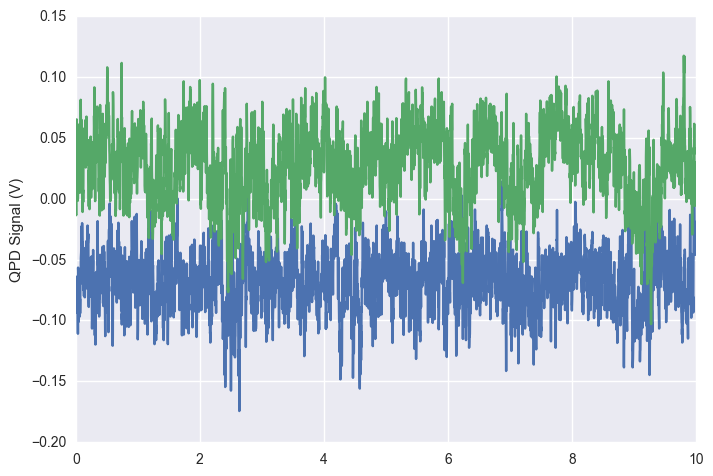

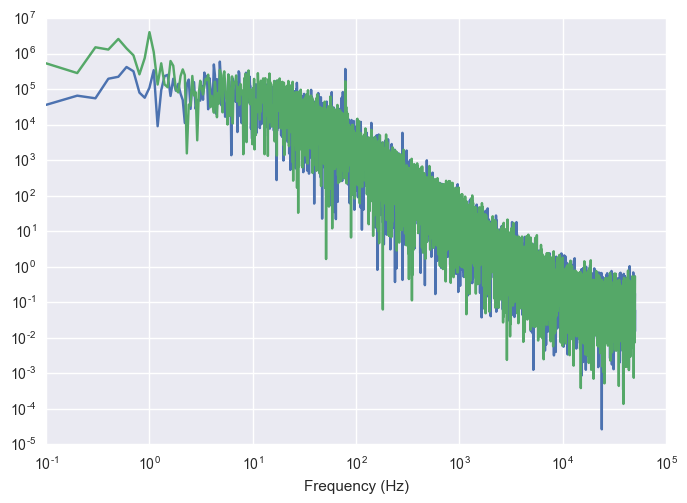

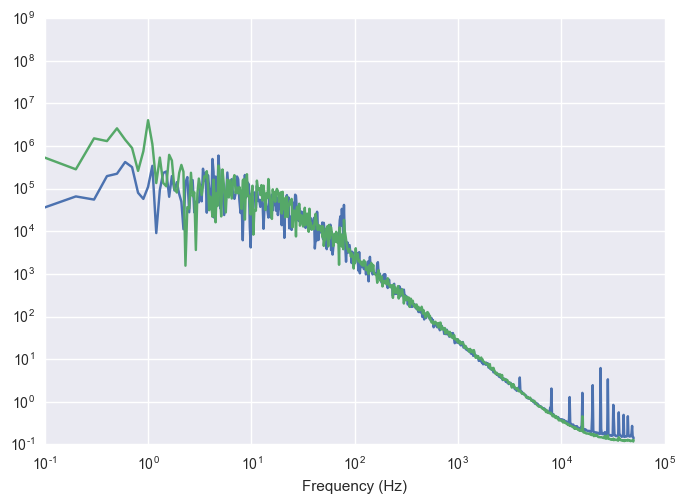

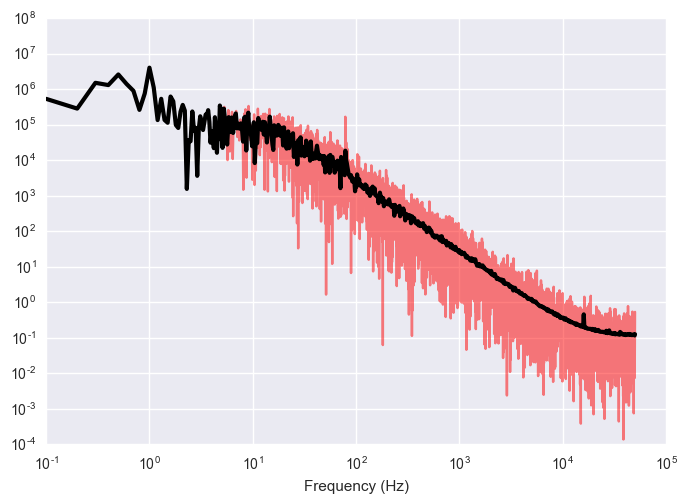

In [5]:
#Data consists of like 1000000 points or more.
#I don't want to plot all data points or I'll crash the computer.
#So, let's sample 2000 points only
plt_points = np.linspace(0,len(saved_data_ps['inputData_0'])-1,min(4000,len(saved_data_ps['inputData_0'])),dtype=np.int)

data_time = np.arange(0,len(saved_data_ps['inputData_0']))/saved_data_ps['Fs'] #time points

#First, we'll plot the qpd signal
#The qpd signal is saved as 'inputData_0' (for x-axis) and 'inputData_1' (for y-axis)
fig,ax1 = plt.subplots()
ax1.plot(data_time[plt_points], saved_data_ps['inputData_0'][plt_points])
ax1.plot(data_time[plt_points], saved_data_ps['inputData_1'][plt_points])
ax1.set_ylabel("QPD Signal (V)") #Units of Volts -- we can convert to microns later

#Take the Fourier transform of the qpd signal and square it. That's the power spectrum
nfft = len(saved_data_ps['inputData_0'])
ps_0 = np.abs(np.fft.rfft(saved_data_ps['inputData_0']))**2 / (nfft/saved_data_ps['Fs'])
ps_1 = np.abs(np.fft.rfft(saved_data_ps['inputData_1']))**2 / (nfft/saved_data_ps['Fs'])
time_step = 1./saved_data_ps['Fs'] #inverse of sampling frequency is time interval
freqs = np.fft.rfftfreq(len(saved_data_ps['inputData_0']), time_step)
idx = np.argsort(freqs)

#Plot the power spectrum
plt_points_freq = np.geomspace(1,len(freqs)-1,min(8000,len(saved_data_ps['inputData_0'])),dtype=np.int)
fig2,ax2 = plt.subplots()
ax2.loglog(freqs[idx][plt_points_freq], ps_0[idx][plt_points_freq])
ax2.loglog(freqs[idx][plt_points_freq], ps_1[idx][plt_points_freq])
ax2.set_xlabel("Frequency (Hz)")

#Let's average the data.
binning = np.geomspace(1,len(saved_data_ps['inputData_0']),num=1024,endpoint=False,dtype=np.int)
freqs_new = []; ps_0_new = []; ps_1_new = []
freqs_used = freqs[idx]#[len(freqs)/2:]
ps_0_used = ps_0[idx]#[len(freqs)/2:]
ps_1_used = ps_1[idx]#[len(freqs)/2:]
j=0
for i,space in enumerate(binning):
    if j<len(freqs_used):
        freqs_new.append(freqs_used[j:j+space].mean())
        ps_0_new.append(ps_0_used[j:j+space].mean())
        ps_1_new.append(ps_1_used[j:j+space].mean())
        j=j+space
    else:
        break

#Turn those lists into arrays
freqs_new = np.array(freqs_new); ps_0_new = np.array(ps_0_new); ps_1_new = np.array(ps_1_new)
        
#Plot the averaged power spectrum
fig3,ax3 = plt.subplots()
ax3.loglog(freqs_new, ps_0_new)
ax3.loglog(freqs_new, ps_1_new)
ax3.set_xlabel("Frequency (Hz)")

#Plot the averaged power spectrum with the raw power spectrum (just to make pretty plot)
#Just do the y-axis
fig4,ax4 = plt.subplots()
ax4.loglog(freqs[idx][plt_points_freq], ps_1[idx][plt_points_freq], '-r', alpha=0.5)
ax4.loglog(freqs_new, ps_1_new,'-k',lw=3)
ax4.set_xlabel("Frequency (Hz)")

In [6]:
def theoreticalPS(f,fc,A):
    return A/(f**2 + fc**2)

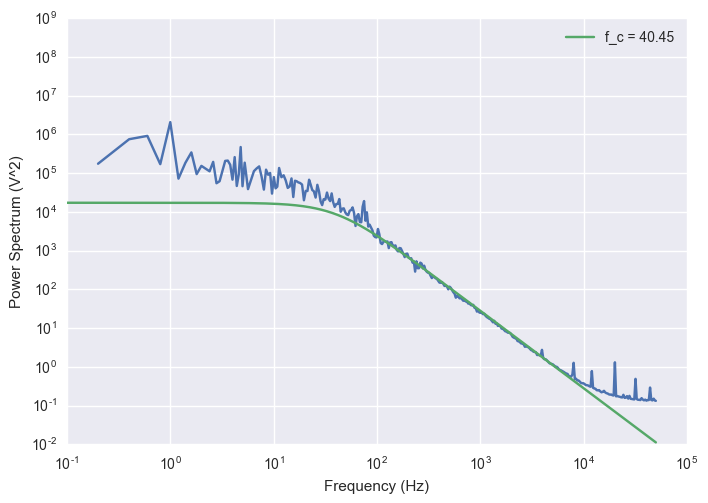

In [9]:
def plot_results(f, fc, logA, title=''):
    fig,ax = plt.subplots()
    ax.loglog(f[::2], 0.5*(ps_1_new+ps_0_new)[::2])
    ax.loglog(f, theoreticalPS(f, fc, 10**logA), label="f_c = %.2f"%fc)
    ax.legend()
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Power Spectrum (V^2)")
    ax.set_title(title)
    
interact(plot_results, f=fixed(freqs_new), fc=(0.9,80.0), logA=(3.0,11.0,0.05), continuous_update=False)

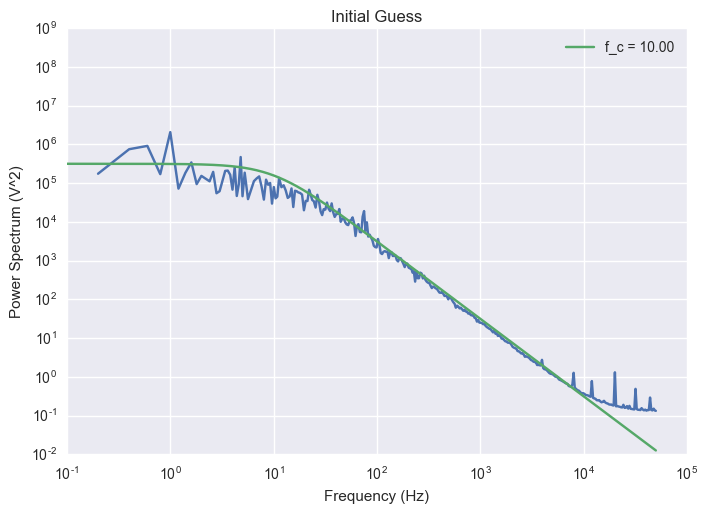

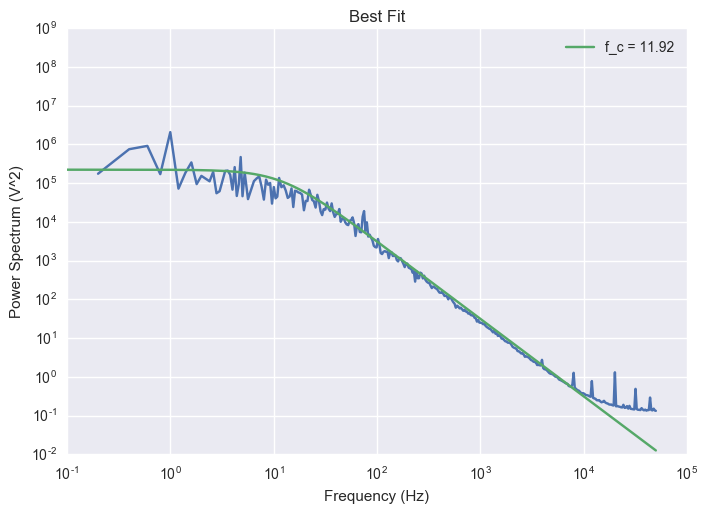

In [13]:
def theoryPSerror(params, dataPS, freqs):
    theoretical_model = theoreticalPS(freqs, params[0], params[1])
    return np.log(abs(dataPS-theoretical_model))

initGuess = np.array([10.0, 10**7.5])
fit_results, flag = leastsq(theoryPSerror, initGuess, args=(0.5*(ps_0_new+ps_1_new), freqs_new))

plot_results(freqs_new, initGuess[0], np.log10(initGuess[1]), title="Initial Guess")
plot_results(freqs_new, fit_results[0], np.log10(fit_results[1]), title="Best Fit")


In [14]:
fit_results

array([  1.19213888e+01,   3.16341395e+07])